In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe


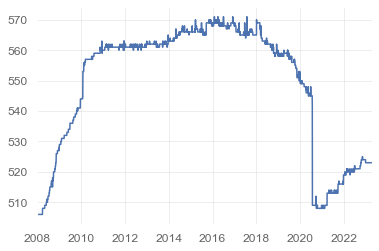

In [311]:

universe = master.baskets.get_index_historical_components('GSPC')
P = func.presence_matrix(universe).loc['2008':]
P.sum(1).plot()
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
# P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
income_statement = pd.read_parquet('data/US/income_statement.pq')

In [8]:
from scipy.stats import kendalltau
market_data[['close','volume']].groupby(level=).apply(lambda x : kendalltau(x['close'],x['volume'])[0])

Ticker
A      -0.379281
AA     -0.322206
AAL    -0.060572
AAP    -0.232710
AAPL    0.173485
          ...   
ZBH    -0.248024
ZBRA    0.111893
ZION   -0.389509
ZMH     0.199674
ZTS    -0.382111
Length: 866, dtype: float64

In [10]:
close = market_data['close'].unstack().reindex_like(P).ffill().rolling(252).rank(axis=0,pct=True,ascending=True)
volume = market_data['volume'].unstack().reindex_like(P).ffill().rolling(252).rank(axis=0,pct=True,ascending=True)

C:\Users\marti\AppData\Local\Temp\ipykernel_25460\3475526474.py:1: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  close = market_data['close'].unstack().reindex_like(P).ffill().rolling(252).rank(axis=0,pct=True,ascending=True)
C:\Users\marti\AppData\Local\Temp\ipykernel_25460\3475526474.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  volume = market_data['volume'].unstack().reindex_like(P).ffill().rolling(252).rank(axis=0,pct=True,ascending=True)


In [52]:
from tqdm import tqdm
kendall_tau = {}
for ticker in tqdm(P.columns.tolist()):
    df = pd.DataFrame({'close':close[ticker],'volume':volume[ticker]})
    # df = df.rolling(10).rank(axis=0,pct=True,ascending=False)
    kendall_tau[ticker]= df.rolling(90).corr(method='kendall').xs('close',level=1)['volume']

  0%|          | 0/863 [00:00<?, ?it/s]C:\Users\marti\AppData\Local\Temp\ipykernel_25460\2594532298.py:6: FutureWarning: Passing additional kwargs to Rolling.corr has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  kendall_tau[ticker]= df.rolling(90).corr(method='kendall').xs('close',level=1)['volume']
C:\Users\marti\AppData\Local\Temp\ipykernel_25460\2594532298.py:6: FutureWarning: Passing additional kwargs to Rolling.corr has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  kendall_tau[ticker]= df.rolling(90).corr(method='kendall').xs('close',level=1)['volume']
C:\Users\marti\AppData\Local\Temp\ipykernel_25460\2594532298.py:6: FutureWarning: Passing additional kwargs to Rolling.corr has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  kendall_tau[ticker]= df.rolling(90).corr(method='kendall').xs('close',level=1)['volume'

In [56]:
# kendall_tau = pd.concat(kendall_tau,axis=1)
kendall_tau_csrank = kendall_tau.rank(1,pct=True,ascending=True).clip(0.01,.99).apply(norm.ppf)
delta_close_csrank = close.diff(3).rank(1,pct=True,ascending=True).clip(0.01,.99).apply(norm.ppf)
diff  = kendall_tau_csrank - delta_close_csrank

C:\Users\marti\AppData\Local\Temp\ipykernel_25460\2784335285.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = diff[P].rolling(25).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
C:\Users\marti\AppData\Local\Temp\ipykernel_25460\2784335285.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)


Sharpe      0.2
Turnover    1.0
biais       0.2
dtype: float64

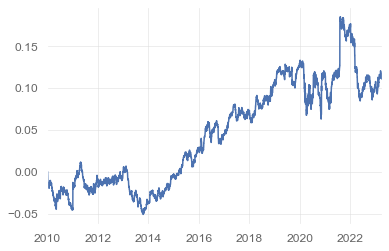

In [58]:
signal = diff[P].rank(1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf).ffill()
signal = diff[P].rolling(25).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.7] = None

signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal.abs().sum(1),0)


pnl = (signal[P].shift()*R).sum(1).loc['2010':]
sr = sharpe(pnl)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
pnl.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl.mean()*1e4}).round(1)


# neg(mult(csrank(std_10(high)),cor_10(high,volume)))


In [284]:


high = market_data['volume'].unstack().pct_change(5).rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
std_10 = market_data['high'].groupby(level=1).rolling(5).std().droplevel(0).unstack().reindex_like(P)
volume = market_data['volume'].unstack().pct_change(5).rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
from tqdm import tqdm
kendall_tau = {}
for ticker in tqdm(P.columns.tolist()):
    try : 
        df = pd.DataFrame({'high':high[ticker],'volume':volume[ticker]}).dropna()
      
        kendall_tau[ticker]= df.rolling(5).corr().xs('high',level=1)['volume']
    except :
        kendall_tau = kendall_tau

100%|██████████| 863/863 [00:09<00:00, 94.08it/s] 


In [274]:
close = market_data['close'].unstack()
mean_change_ret = close.pct_change(5).mean(1).rolling(252).mean()
std_change_ret = close.pct_change(5).std(1).rolling(252).mean()
feature_1 = (close.pct_change().sub(mean_change_ret,0))#.div(std_change_ret,0)
feature_1 = feature_1.rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)


volume = market_data['volume'].unstack()
mean_change_volume = volume.pct_change(3).rolling(252).mean()
std_change_volume = volume.pct_change(3).rolling(252).std()
feature_2 = (volume.pct_change().sub(mean_change_volume,0))#.div(std_change_volume,0)
feature_2 = feature_2.rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

from tqdm import tqdm
kendall_tau = {}
for ticker in tqdm(P.columns.tolist()):
    try : 
        df = pd.DataFrame({'high':feature_1[ticker],'volume':feature_2[ticker]}).dropna()
      
        kendall_tau[ticker]= df.rolling(5).corr().xs('high',level=1)['volume']
    except :
        kendall_tau = kendall_tau



100%|██████████| 904/904 [00:09<00:00, 90.56it/s] 


In [356]:
close = market_data['close'].unstack()
mean_change_ret = close.diff(5).rolling(50).mean()
std_change_ret = close.diff(5).rolling(50).std()
feature_1 = (close.diff(5))# - mean_change_ret)#/std_change_ret
feature_1 = feature_1.rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)


volume = market_data['volume'].unstack()
mean_change_volume = volume.diff(5).rolling(50).mean()
std_change_volume = volume.diff(5).rolling(100).std()
feature_2 = (volume.diff(5))# - mean_change_volume)#/std_change_volume
feature_2 = feature_2.rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
from tqdm import tqdm
kendall_tau = {}
for ticker in tqdm(P.columns.tolist()):
    try : 
        df = pd.DataFrame({'high':feature_1[ticker],'volume':feature_2[ticker]}).dropna()
      
        kendall_tau[ticker]= df.rolling(5).cov().xs('high',level=1)['volume']
    except :
        kendall_tau = kendall_tau



100%|██████████| 863/863 [00:08<00:00, 103.14it/s]


In [357]:
alpha = pd.concat(kendall_tau,axis=1).reindex_like(P).ffill()
mean_change_ret.stack()

Date        Ticker
2008-05-06  A        -0.003200
            AA       -0.084604
            AAL      -0.524400
            AAP       0.125200
            AAPL      5.990824
                        ...   
2023-04-05  YUM       0.431600
            ZBH       0.419400
            ZBRA      0.769800
            ZION     -2.159800
            ZTS       0.292000
Length: 394034, dtype: float64

C:\Users\marti\AppData\Local\Temp\ipykernel_25460\4286008641.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(252).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf).ffill()
C:\Users\marti\AppData\Local\Temp\ipykernel_25460\4286008641.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)


Sharpe      0.4
Turnover    0.5
biais       0.5
dtype: float64

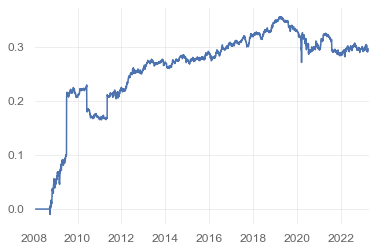

In [358]:
signal = alpha[P].rank(1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf).ffill()
signal = signal[P].rolling(252).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf).ffill()
signal = signal[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf).ffill()
signal[signal.abs()<0.5] = None

signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)
signal = signal[P].div(signal.abs().sum(1),0)


pnl = (signal[P].shift()*R).sum(1)
sr = sharpe(pnl)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
pnl.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl.mean()*1e4}).round(1)

<Axes: >

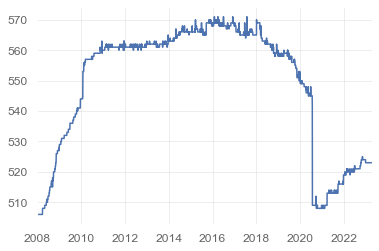

In [307]:
P.sum(1).plot()